<div class="alert alert-block alert-info"><h3>IFN619 Data Analysis for Strategic Decision Making - Assignment 1 Part B</h4></div>

In [1]:
# import the library for both Q2 and Q3

# for data loading and cleaning
import numpy as np                  
import pandas as pd             
import sys
!{sys.executable} -m pip install nltk
import nltk
from nltk.corpus import stopwords
from collections import Counter

# for Bayesan Networks (BNs)
import os
import math
import pyAgrum as bn_graphs
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC

# for Topic Classification and Topic Modelling
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import GaussianNB       # Naive Bayes Classifier based on a Gaussian Distribution
from sklearn.naive_bayes import MultinomialNB    # Naive Bayes Classifier based on a Multinomial Distribution
from pprint import pprint
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
import pickle

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# for Visualisation
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns           
sns.set()
!{sys.executable} -m pip install WordCloud
from wordcloud import WordCloud
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Quenstion 3
What were the top Australian news topics over the last decade, and what can these say about the national conversation?

<img src="img/banner3.jpg"/>

## 1. Introduction

The social media plays a vital role in shaping the public's opinions. With the development of WeMedia (or Self-Media), Michael, who leads a group of people working in creative industry for 5 years is going to develop a social media page in Facebook with his team during this special period at home due to COVID-19. They hope to use this page to express their reviews and comments on hot topics in Australia. However, they have no ideas which specific topic(s) in Australia could attract more people to read or subscribe their account.

In this case, we as a startup digital marketing consulting company are invited to conduct the topic analysis based on the data from abcnews headlines over the last decade, and provide some advice for the contents (including the headlines) of their new social media page. 

This case will also be appliable for other WeMedia if they want to increase their clicks and hits using same techniques by feeding more hot topics abcnews is talking about.

### 1.1 Scope

In this analysis, the scope is the news topics over the last decade from abcnews headlines as required by the clients here.

### 1.2 Stakeholder(s)

WeMedia Group

### 1.3 Questions

The main business concern is to identify the top Australian news topics over the last decade and know what can these say about the national conversations, so that the stakeholders can figure out how to design and edit the contents and topics in their own social media pages.

The questions according to the business concern are list as follows,
- What are the most-common words mentioned in the news headlines over last decade from abcnews?
- What are the most popular Australian news topics in the past 10 years from abcnews?
- What are people talking about in terms of the top words within the top 10 topics in the last decade?
- What kind of topic(s) might bring more abcnews readers' attentions when we promote our social media pages?

### 1.4 Approach

<img src="img/process.png" />
<center>source: ifn619 lecture</center>

## 2. Data


### 2.1 Collect / Load Data

The data in this analysis is downloaded from [A Million News Headlines](https://www.kaggle.com/therohk/million-headlines) in Kaggle.<br>**Sourced** from the reputable Australian news source ABC (Australian Broadcasting Corp.)<br> **Start Date**: 2003-02-19 ; **End Date**: 2019-12-31  
**About:** doi.org/10.7910/DVN/SYBGZL

As one of the famous public news service in Australia, ABC News can provide credible information about the national conversations and also show the news trending over the last decade. Further, the stakeholders are going to attract more ABC News' readers to develop their social media page, so they will be benefit from the data directly from ABC News. 

In [30]:
# load the data
data = pd.read_csv('RawData/abcnews-date-text.csv')
data.head(5)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [31]:
# overview of the data: know the data type and data shape
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186018 entries, 0 to 1186017
Data columns (total 2 columns):
publish_date     1186018 non-null int64
headline_text    1186018 non-null object
dtypes: int64(1), object(1)
memory usage: 18.1+ MB


(1186018, 2)

### 2.2 Data Cleaning

It is required to identify the top topics over last decade, so only the data during 2010-2019 will be analysed at this stage.

In [32]:
data["publish_year"] = data["publish_date"].astype(str).str[:4].astype(np.int64)
abc = data.loc[data['publish_year'].isin(['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'])]
abc.index = range(len(abc))
abc

,publish_date,headline_text,publish_year
0,20100101,12m degas stolen from museum,2010
1,20100101,17 die in bangladesh bus crash,2010
2,20100101,2010 to be drier after very wet 2009,2010
3,20100101,37 catholic workers killed worldwide,2010
4,20100101,600 hurt in philippine new year revelry,2010
...,...,...,...
675708,20191231,vision of flames approaching corryong in victoria,2019
675709,20191231,wa police and government backflip on drug amne...,2019
675710,20191231,we have fears for their safety: victorian premier,2019
675711,20191231,when do the 20s start,2019


In [33]:
# have an overview of the numbers of headlines in each year
news_counts = abc.groupby('publish_year')['headline_text'].count()
news_counts

publish_year
2010    74931
2011    77778
2012    89008
2013    91928
2014    81531
2015    77290
2016    61574
2017    47511
2018    40102
2019    34060
Name: headline_text, dtype: int64

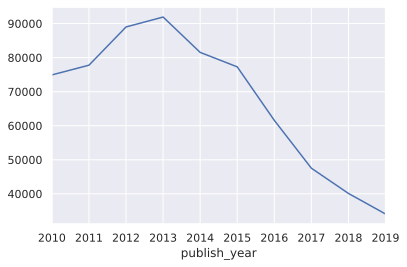

In [34]:
news_counts.plot()

<div class="alert alert-block alert-success">
<b>Insight Notes:</b>
    It can be firstly noticed the headlines covered in this dataset were rapidly decreased from 2013 which might affect our final analysis due to the unbalanced data in each year.       </div>

In [35]:
# remove the stopwords (meaningless words) in headline column
stop = stopwords.words('english')
# apply(lambda x:) means apply conditions in the specific column
headlines = abc['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[Stemming and Lemmatisation](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) are also conducted at the beginning. <br>However, it was found that it would make some words incomplete and some particular words cannot be figure out after cleaning. (e.g. bus -> bu, "wa" was removed)

In [36]:
# remove the number in headlines because the number does not contribute to the topic modelling in this analysis
regex_1 = r'[0-9]+[a-z]' 
regex_2 = r'[0-9]'
abc['headline_cleaned'] = headlines.str.replace(regex_1,'')
abc['headline_cleaned'] = abc['headline_cleaned'].str.replace(regex_2,'')

**Display the cleaned dataframe**

In [37]:
abc = abc[['publish_date','publish_year','headline_text','headline_cleaned']]
abc

,publish_date,publish_year,headline_text,headline_cleaned
0,20100101,2010,12m degas stolen from museum,degas stolen museum
1,20100101,2010,17 die in bangladesh bus crash,die bangladesh bus crash
2,20100101,2010,2010 to be drier after very wet 2009,drier wet
3,20100101,2010,37 catholic workers killed worldwide,catholic workers killed worldwide
4,20100101,2010,600 hurt in philippine new year revelry,hurt philippine new year revelry
...,...,...,...,...
675708,20191231,2019,vision of flames approaching corryong in victoria,vision flames approaching corryong victoria
675709,20191231,2019,wa police and government backflip on drug amne...,wa police government backflip drug amnesty bins
675710,20191231,2019,we have fears for their safety: victorian premier,fears safety: victorian premier
675711,20191231,2019,when do the 20s start,start


## 3. Analysis & Visualisation

**Natural Language Processing** problem is covered in this analysis, and we are mainly focus on **Topic Modelling** by using some relevant techniques as we are required to tag the top topics in analysis.

There are **FOUR** steps in this part:<br>
1) **General Analysis**: the word frequency will be counted throughout the cleaned headlines, and show the **most popular words** as a overview of the headlines by using *WordCloud*.<br>
2) **Topic Classifications**: *Naive Bayes Classifer* will be applied here to classify the topic for each healine and identify the specific **top topics**. <br>
3) **Topic Modelling**: *Non-Negative Matrix Factorization (NMF)* will be applied to identify the **top 10 topic cluster** with **top 10 words**. <br>
4) **Analysis Result Summary**

### 3.1 General Analysis

First, let's have a general view of what are the most popular words over the last 10 years?

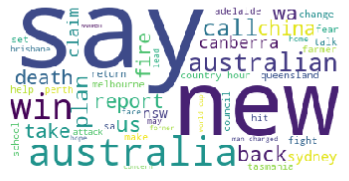

In [38]:
head = " ".join(abc['headline_cleaned'].values.tolist())
wordcloud = WordCloud(max_words = 50, background_color='white',stopwords=None).generate(head)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Now that we have a rough view of the popular words over the last decade, but what are the exact frequencies of them?   
Let's identify the most-common 20 words based on their word frequencies.

In [39]:
headline_count = Counter(" ".join(abc['headline_cleaned'].values.tolist()).split())
headline_count.most_common(20)

[('police', 18498),
 ('new', 17903),
 ('man', 16980),
 ('says', 13681),
 ('interview', 12272),
 ('australia', 10876),
 ('australian', 9783),
 ('court', 9629),
 ('nsw', 9243),
 ('us', 8394),
 ('fire', 8230),
 ('government', 7730),
 ('wa', 7595),
 ('sydney', 7563),
 ('council', 7324),
 ('rural', 6841),
 ('death', 6636),
 ('day', 6636),
 ('charged', 6289),
 ('murder', 6162)]

<div class="alert alert-block alert-success">
<b>Insight Notes:</b><br>From the wordcloud and the result of the most-common 20 words throughout the cleaned headlines, it is found that:<br>
<li>"police" is the top first word in the headlines, it might be related to the criminal justice issues linking to other popular words such as "court" and "murder", but it could also be related to the politics.
<li>"say" is highly frequent, this might give us information that there were lots of interviews ("interview" is another top word) or talkings from famous people. 
<li> "australia/australian" as well as some states and capital cities such as "nsw", "wa", "canberra", "sydney" appear a lot, which might mean abcnews put more emphasis on the statewide news and things happened in capital cities. 
<li>"fire" is another word draw our attentions due to the unprecedented bushfires started from 2019. 
<li>"china" was also a popular word as shown in wordcloud, it may due to the close trade relationship, or other political issues, or even international students or immigrants from china.
<br>However, we are not able to draw any conclusions here because we have not taken the specific headlines into account. The meanings of the words vary in different scenarios. Hence further analysis is needed as follows.</div>

### 3.2 Topic Classifications

So let's discover what specific topic it is belonging to headline by headline.  
Here, we are using Naive Bayes Classifier to help us categorise every healine into 20 news topics by applying machine learning techniques.    
* [20newsgroups](http://qwone.com/~jason/20Newsgroups/) is a dataset widely used for text classification or text cluster.

In [40]:
# fetch 20 news topics from 20newsgroups dataset

newsgroups_train = fetch_20newsgroups(subset='train')
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [41]:
# set the training and testing set with 20 news topics
headlines = [value[3] for value in abc.iloc[0:].values]
categories = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [42]:
X_train_raw = train.data
y_train = train.target
X_test_raw = test.data
y_test = test.target
y_expected = test.target

In [43]:
# Extract textual features from text
vec = TfidfVectorizer()
X_train = vec.fit_transform( X_train_raw )
X_test = vec.fit_transform( X_test_raw )

In [44]:
# build the model and print the model accuracy
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(train.data, train.target)
y_predicted  = model.predict(test.data)
print( 'The overall accuracy of the model is %.2f%%' %(accuracy_score( y_expected, y_predicted )*100))

The overall accuracy of the model is 77.39%


Text(80.90000000000005, 0.5, 'predicted label')

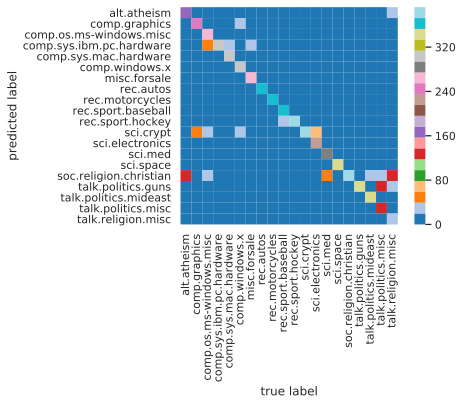

In [45]:
# plot the confusion matrix to evaluate the performance of the classification model
colormap = "tab20"
mat = confusion_matrix(test.target, y_predicted)
sns.heatmap(mat.T, square=True, annot=False, fmt='d', cbar=True, cmap = colormap,
            xticklabels=train.target_names, yticklabels=train.target_names)
#plt.figure(figsize=(10,6))  
plt.xlabel('true label')
plt.ylabel('predicted label')

<div class="alert alert-block alert-success">
<b>Insight Notes:</b><br>
From the result of the model accuracy and the confusion matrix, it can be noticed that most of the classifications can be categorised well, deviations mainly occured in the topics of "Science.Cryptography", "Social.Religien.Christian", "Talk.Politics.Guns" and "Computers". <br>So we should consider this situation as a gap when we propose our insights or recommendations to the stakeholders.</div>

In [46]:
def predict_category(s, train=train, model=model):
    topic_pred = model.predict([s])
    return train.target_names[topic_pred[0]]

In [47]:
Headline=[]
Topic=[]
for head in headlines:
    Headline.append(head)
    Topic.append(predict_category(head))
df = pd.DataFrame(list(zip(abc['publish_year'],Headline, Topic)), 
               columns =['Year','Headline', 'Topic']) 

Here is the result of the topic classification based on the model we build.

In [48]:
df

,Year,Headline,Topic
0,2010,degas stolen museum,talk.politics.mideast
1,2010,die bangladesh bus crash,comp.sys.ibm.pc.hardware
2,2010,drier wet,comp.os.ms-windows.misc
3,2010,catholic workers killed worldwide,soc.religion.christian
4,2010,hurt philippine new year revelry,rec.sport.baseball
...,...,...,...
675708,2019,vision flames approaching corryong victoria,rec.sport.hockey
675709,2019,wa police government backflip drug amnesty bins,sci.crypt
675710,2019,fears safety: victorian premier,talk.politics.guns
675711,2019,start,rec.sport.baseball


But how frequent of these topics over the last decade? Let's see..

In [49]:
count = df.groupby(['Year','Topic'])['Headline'].count().unstack()
topics = count.mean()
topics = topics.sort_values(ascending=False)

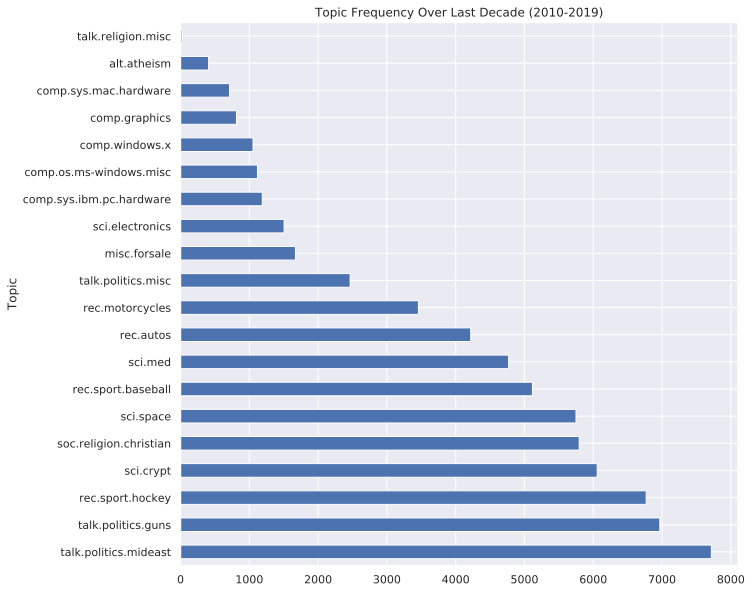

In [50]:
topics.plot(kind="barh",title = "Topic Frequency Over Last Decade (2010-2019)",figsize=(10,10))

In [51]:
print("It is obviously found that the top 10 topics are: ")
top = pd.DataFrame(topics[:10])
top.to_csv('Top Topics.csv')
top = pd.read_csv('Top Topics.csv')
top.rename(columns={'0':'Number of Topics'},inplace=True)
top

It is obviously found that the top 10 topics are: 


,Topic,Number of Topics
0,talk.politics.mideast,7716.5
1,talk.politics.guns,6967.1
2,rec.sport.hockey,6769.3
3,sci.crypt,6057.0
4,soc.religion.christian,5795.3
5,sci.space,5749.0
6,rec.sport.baseball,5116.0
7,sci.med,4770.2
8,rec.autos,4218.8
9,rec.motorcycles,3457.7


But were these topics being always the top topics in the past 10 years? Or some of them were only booming during special years?  
Then we could have a look at it through the table and chart below by years. In the table, the percentages of each topic occupied in each year are calculated, and the trend of each topic are displayed in the line chart.<br>
* *We use the percentages here rather than just counting the numbers of each topic in each year because as we have known from the plot at the beginning, the number of headlines in each year is quite different which will lead to a big deviations in the analysis.*

In [52]:
counts = (df.groupby(['Year','Topic'])['Headline'].count()*100/df.groupby(['Year'])['Headline'].count()).unstack()
counts.round(2)

Topic,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
Year,,,,,,,,,,,,,,,,,,,,
2010,0.56,1.06,1.64,1.62,0.94,1.61,2.46,6.73,5.91,8.68,9.72,8.85,2.07,6.99,7.95,8.73,10.46,10.24,3.77,0.02
2011,0.53,1.20,1.60,1.88,1.11,1.76,2.71,6.68,5.37,7.97,10.67,8.72,2.33,6.52,8.38,8.05,9.91,10.93,3.66,0.03
2012,0.56,1.12,1.65,1.89,1.14,1.77,2.64,6.41,5.05,7.74,10.83,9.42,2.33,6.73,8.81,7.94,9.91,10.61,3.43,0.02
2013,0.55,1.20,1.65,1.77,1.09,1.73,2.48,6.59,5.31,7.36,10.21,9.17,2.31,6.96,8.45,7.90,10.66,10.84,3.75,0.03
2014,0.66,1.27,1.59,1.90,1.11,1.55,2.55,6.11,4.86,7.49,10.44,8.87,2.34,7.46,8.86,7.94,9.73,11.80,3.45,0.02
2015,0.70,1.22,1.92,1.77,1.02,1.40,2.34,6.09,4.77,6.97,10.37,8.67,2.17,7.06,8.67,8.29,10.18,12.95,3.41,0.04
2016,0.61,1.19,1.67,1.67,0.96,1.31,2.34,6.00,4.81,6.85,9.07,9.18,2.18,7.40,8.81,9.21,10.73,11.91,4.05,0.06
2017,0.65,1.29,1.59,1.68,0.99,1.24,2.20,5.59,4.83,7.22,9.21,9.27,2.16,7.24,8.22,10.36,10.52,11.96,3.71,0.06
2018,0.65,1.29,1.58,1.54,1.12,1.32,2.40,5.62,5.16,7.89,8.76,8.66,1.97,7.51,8.11,10.16,10.49,12.09,3.64,0.05


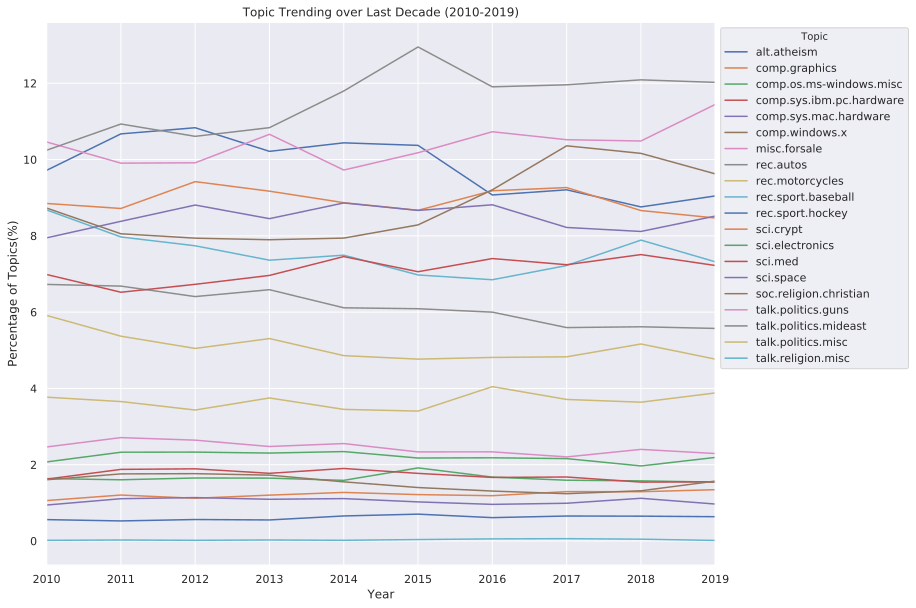

In [53]:
plot = counts.plot(ax=plt.axes(title="Topic Trending over Last Decade (2010-2019)",ylabel = "Percentage of Topics(%)"),figsize=(12,10) )
plot.get_legend().set_bbox_to_anchor((1, 1))

<div class="alert alert-block alert-success">
<b>Insight Notes:</b><br>
It can be noticed the trend of each topic is relatively stable within a timeframe specially for the least-common ones.  <br> 
Furthermore, responding to the top 10 topics throughout 10 years we get before, it is apparently known the topic of "politics.mideast" was always popular and even went to the peak point in 2015. After searching the internet about what was happening in the middle east in 2015, it was a crisis for the middle east in 2015 and the political situation there changed due to the regional conflicts, and the large numbers of people were dying during that period, all of these were enough to get the world's attention not even Australia.
</div>

*[What's happening in the Middle East and why it matters](https://edition.cnn.com/2015/01/23/middleeast/middle-east-country-breakdown/index.html)*

---
Incorporate with both "topic frequency" and the relatively stable "topic trending" over the last decade, we could have a clue about the top 10 topics. (The ranking would slightly change in different year.)

In [54]:
# to make the result clear to understand, the name of the orginal categories were made up without abbreviations.
top.rename(columns={'Topic':'Topic Category'},inplace=True)
top['Main Topic'] = top['Topic Category'].map(lambda x:x.split('.')[0])
top['Sub Topic'] = top['Topic Category'].map(lambda x:x.split('.')[1])
top['Main Topic'].replace(['talk','sci','soc','rec'],['Talk','Science','Sociology','Recreation'],inplace=True)
top['Sub Topic'].replace(['crypt','med'],['cryptography','medical'],inplace=True)
top = top[['Main Topic','Sub Topic','Topic Category','Number of Topics']]
top

,Main Topic,Sub Topic,Topic Category,Number of Topics
0,Talk,politics,talk.politics.mideast,7716.5
1,Talk,politics,talk.politics.guns,6967.1
2,Recreation,sport,rec.sport.hockey,6769.3
3,Science,cryptography,sci.crypt,6057.0
4,Sociology,religion,soc.religion.christian,5795.3
5,Science,space,sci.space,5749.0
6,Recreation,sport,rec.sport.baseball,5116.0
7,Science,medical,sci.med,4770.2
8,Recreation,autos,rec.autos,4218.8
9,Recreation,motorcycles,rec.motorcycles,3457.7


### 3.3 Topic Modelling
Even we know the top topics over the last decade, we are more curious about what were the conversation about in these topics?  
In this step with topic modelling technique by [NMF(Non-negative Matrix Factorization)](https://mlexplained.com/2017/12/28/a-practical-introduction-to-nmf-nonnegative-matrix-factorization/), we can dig more details of those popular topics.

<img src="img/why NMF.png" />
<center>Figure: Why NMF?</center>

In [59]:
# prepare for the NMF model: TF-IDF (Term Frequency — Inverse Document Frequency)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000)
tfidf = tfidf_vectorizer.fit_transform(headlines)

In [60]:
# select top 10 topics
num_topics = 10                                                                

In [61]:
# develop a NMF model
model = NMF(n_components=num_topics, init='nndsvd').fit(tfidf)

In [62]:
# generate NMF Topics
# obtain the most important scoring words in each cluster, and add them to a Dataframe
def get_nmf_topics(model, n_top_words):
    
    # the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    # feat_names = vectorizer.get_feature_names()
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    word_dict = {}
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-10 - 1:-1]
        words = [tfidf_feature_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
    
    return pd.DataFrame(word_dict)

get_nmf_topics(model,10).T

,0,1,2,3,4,5,6,7,8,9
Topic # 01,interview,extended,michael,david,john,james,ben,smith,matt,andrew
Topic # 02,man,charged,murder,court,accused,dies,woman,crash,death,found
Topic # 03,rural,news,national,nsw,reporter,sa,exchange,qld,friday,thursday
Topic # 04,abc,weather,sport,business,news,entertainment,market,analysis,speaks,stories
Topic # 05,country,hour,nsw,tas,wa,august,drum,vic,october,september
Topic # 06,new,zealand,year,york,laws,hospital,years,centre,deal,home
Topic # 07,police,search,probe,investigate,missing,officer,car,crash,hunt,death
Topic # 08,says,australian,government,us,council,health,election,nsw,wa,report
Topic # 09,australia,day,world,one,south,cup,test,vs,first,two
Topic # 10,fire,house,sydney,crews,home,woman,destroys,suspicious,blaze,dies


<div class="alert alert-block alert-success">
<b>Insight Notes:</b><br>
Here above, we get a dataframe describing the top 10 topics with top 10 words in each.  <br>
Generally, the topic words are matching with the wordcloud we have had in step 3.1, and the topic cluster can also be summarised linking to the top 10 topics we conclude in step 3.2.                                                                                      
</div>

### 3.4 Analysis Result Summary

Finally, according to the results from 3.1 to 3.3, we could have a more comprehensive view of the top topics including the topic words about the abcnews during 2010-2019.

<img src="img/Q3 Summary.jpg" />

After this, we can incorporate with the results from 3.1 to 3.3 to draw some meaningful insights overall.

## 4. Insights

Some insights can be initiated based on the analysis results in section 3.
- Topics about the politics, recreation, science and sociology were the top topics in ABC News from 2010 to 2019. 
- The topic trend was relatively stable throughout the last 10 years except for the booming topic of middle east politics in 2015 due to the crisis in those areas.
- Politics were the hot topics in ABC News indeed. The political news about the middle east was always being the top 3 topics over the last decade. Meanwhile, the political news about the US, New Zealand and China were involved in the national conversations as well. Even the news about politicians was also very popular on ABC News.  
    This might give some hints for the stakeholder to develop their own social media page: they could add some comments on political news. However, this should be considered seriously as a "WeMedia" talking about serious and sensitive political topics.
- The interview was one of the most popular forms of news. The stakeholder could refer to this form in their social media page by increasing the number of interviews to attract more readers.
- Science and sociology topics such as the criminal justice related issues, the "fire" (might be bushfire), the medical issues drew lots of attentions because these kinds of news are closely connected to people's lives not only in Australia but also any other countries around the worlds. So for the stakeholder in this analysis, it is also crucial to keep eyes on these topics which people really care about.  
- It can also be noticed the statewide and national wide news or the news happened in capital cities were widely discussed in news. So for the stakeholder, more discussions on the high-impact events can attract more readers.
- "police" and "court" were quite frequently mentioned in the conversations which means it might be a good idea to introduce some legal knowledge and organise some interviews with legal staff on the page. 
- If the stakeholder decides to focus on the recreation topics, that would be a good start as well especially starting from sports such as hockey. Reviews about the live games would get more clicks and hits in the page according to the top topic words "vs", "live" and "cup".

**Limitations and Future Work** <br>
The top topics with popular words analysed in this report offer the stakeholder a good direction of developing their new social media page. However, this analysis is based on the news from ABC News only, which means the range of the data is a bit narrow and it might affect the analysis result. Further, the data is only from the news headlines without taking the contents into account which would also have impacts on the effectiveness of the analysis. Moreover, to really figure out what kind of topics and contents are more attractive, the number of readers of each news should also be considered. Finally, the accuracy of this model can be improved as well, even different techniques applied in the analysis might lead to  a differnt analysis result. So, to have more accurate and critical analysis results for the stakeholder, future work needs to be executed as listed below.
- Collect more data from a wide range of news medias such as The Age, The Guardian, etc.
- Take the news headlines, contents and the number of readers into account in the analysis to lead a more accurate analysis for the stakehorlder.
- The performance of the model can be improved by further testing with adjustments of some parameters.
- Analysis results should be evaluated before final release.